## Loss and Cost Functions for Logistic Regression
Given $(\mathbf{x}_i,y_i) \in \mathbb{R}^p \times \{0,1\}$ for $i = 1, \ldots, m$, the linear regression algorithm optimizes the mean squared error cost function. This cost function is convex for a linear function $z = {\mathbf{w}^\top}\mathbf{x}_i + b$. In other words, if gradient converges, it will  approach the global minimum of the cost function.

The logistic regression algorithm uses the sigmoid function, $\sigma(z) = (1+e^{-z})^{-1}$, which is exponential. This function isn’t always convex with the mean squared error cost function. Thus, our logistic regression can get stuck in a local minimum. We have to randomly initialize our model and train several times to be sure that we are getting the best results.

We randomly initialized our weights while building the `regularizedLR()` and because we are using a cost function that is always convex with the sigmoid function it shouldn't matter.

The loss function used for training the logistic regression algorithm is called log-loss. It is given mathematically as:

$$\log(loss) = -y_i \cdot \log\hat{y} - (1 – y_i) \cdot \log(1 - \hat{y}),$$where $\hat{y} = \frac{1}{1+e^{-z}}$
The cost function, $J(w, b)$, is just the average of the log-loss function for an epoch:

$$J(w, b) = -{1 \over m}\sum^m_{i=1}y_i \cdot \log\hat{y} + (1 - y_i) \cdot \log(1 - \hat{y})$$

<hr> </hr>

### The Logistic Regression Module with L1 and L2 Regularization
The logistic regression with $L_1$ and $L_2$ regularization uses the $L_1$ and $L_2$ regularization functions. This regularization is called elasticnet and is given mathematically below:

$$J(\mathbf{w}) = -{1 \over m}\sum^m_{i=1}y_i \cdot \log\hat{y} + (1 - y_i) \cdot \log(1 - \hat{y}) + {1 \over m} \sum_{j=1}^p(\beta_1 \cdot |w_i| + {1 \over 2} \cdot \beta_2 \cdot w_i^2),$$
where the parameters $\beta_1$ and $\beta_2$ determine the mixing effect that $L_1$  $L_2$ regularization have on the model’s coefficients.

<hr> </hr>

### Subgradient

The gradient of $J(\mathbf{w})$ wrt $\mathbf{w}$ is calculated as:

$$\nabla_{\mathbf{w}} J = {1 \over m}\sum^m_{i=1}\bigg[(\hat{y_i} – y_i)\mathbf{x}_i + \sum_{j=1}^p(\beta_1 \cdot sign(w_i) + {1 \over 2} \cdot \beta_2 \cdot w_i)\bigg],$$where it is important to note that since $||\mathbf{w}||_1$ is non-differentiable, we are instead using its subgradient,  which has coordinate-wise expression given as follows:

$$\stackrel{sub}{\nabla_i} ||\mathbf{w}||_1 = \begin{cases} sign(w_i) \quad &\text{ if } w_i \neq 0 \\ [-1,1] \quad  &\text{ if } w_i = 0. \end{cases}$$

In [ ]:
"""
    This is logistic regression module
    To use:
        # Import the regularizedLR class from the module and use its methods
        log_reg = regularizedLR()      # Initialization with default params
        log_reg.fit(X, y)    # Fit with train set
        log_reg.predict(X)   # Make predictions with test set
        log_reg.score(X,y)   # Get accuracy score

    Method:
        __init__
        __repr__
        sigmoid
        predict
        predict_proba
        fit
        score
"""

# Define placeholders for stroing iterates, loss function and its gradient values
iterates = []
losses = []
gradients = []

import numpy as np
from sklearn.metrics import accuracy_score

class regularizedLR(object):
    """
    This is the regularizedLR class and by default implements Logistic regression with Lassso penalty (i.e., beta_1 = 1 and beta_2 = 0)
    """

    def __init__(self, learning_rate=10e-3, n_epochs=10000, cutoff=0.5, beta_1 = 1, beta_2 = 0):
        """
        The __init__ method
        Params:
            learning_rate
            n_epochs
            cutoff
            beta_1
            beta_2
        """
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.cutoff = cutoff
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def __repr__(self):
        params = {
            'learning_rate': self.learning_rate,
            'n_epochs': self.n_epochs,
            'cutoff': self.cutoff,
            'beta_1': self.beta_1,
            'beta_2': self.beta_2
        }
        return "regularizedLR({0}={5}, {1}={6}, {2}={7}, {3}={8}, {4}={9})".format(*params.keys(), *params.values())

    @staticmethod
    def reshape(A):
      A = np.block([np.ones((A.shape[0], 1)), A])
      return A

    # regularized logistic loss function
    def J(self, y, yhat, m, w, beta_1, beta_2):
      self.m = y.shape[0]
      return (-1*(y * np.log(yhat) + (1 - y) * np.log(1 - yhat)).mean()    #average logistic loss
                    + beta_1/m * np.linalg.norm(w, ord=1)                  # l1-penalty
                    + beta_2/(2*m)*np.linalg.norm(w, ord=2)                # l2-penalty
            )


    def sigmoid(self, z):
        """
        The sigmoid method:
        Param:
            z
        Return:
            1.0 / (1.0 + exp(-z))
        """
        return 1.0 / (1.0 + np.exp(-z))


    def predict_proba(self, X):
        """
        The predict_proba
        Param:
            row
        Return:
            sigmoid(z)
        """
        z = X@self.w
        return self.sigmoid(z)


    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()

        X = regularizedLR.reshape(X)

        self.predict_probas = []
        ypred = self.predict_proba(X)
        self.predict_probas = ypred

        return (np.array(self.predict_probas) >= self.cutoff) * 1.0


    def score(self, X, y):
        """
        The score method
        Param
            X, y
        Return
            accuracy_score(y, ypred)
        """
        ypred = self.predict(X)
        y = y.to_numpy()
        return accuracy_score(y, ypred)


    def fit(self, X, y):
        """
        The fit method implements sub-gradient descent
        Param
            X, y
        Return
            None
        """
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()

        if not isinstance(y, np.ndarray):
            y = y.to_numpy()

        #reshaping X to fit all one vactor at the end for the bias term
        X = regularizedLR.reshape(X)
        # the extra dimension for bias is already added to w from the extra dimesnion in X

        # initialize the vector, feel free to play with initialization
        np.random.seed(47)
        self.w = np.random.normal(size=(X.shape[1], ))

        self.m = X.shape[0]

        for n_epoch in range(1, self.n_epochs + 1):

            # TODO: get predictions
            '''
            yhat = ...
            '''

            # TODO: calculate the subgradient of the regularized loss
            '''
            grad_w =  ( ...              # gradient of Logistic Loss
                      + ...              # subgradient of l1-penalty
                      + ...              # gradient of l2-penalty
            )
            gradients.append(grad_w)
            '''

            # TODO: write subgradient descent update rule
            '''
            self.w -= ...
            '''
            iterates.append(self.w)

            # TODO: get the loss by using the appropriate function defined above
            '''
            loss = ...
            '''
            losses.append(loss)

# Working with the `regularizedLR` Module

In [ ]:
lr = regularizedLR()

 * Let’s also view the docstrings in the sigmoid and fit methods:

In [ ]:
print(lr.__doc__)
print(regularizedLR.sigmoid.__doc__)
print(regularizedLR.fit.__doc__)


    This is the regularizedLR class and by default implements Logistic regression with Lassso penalty (i.e., beta_1 = 1 and beta_2 = 0)
    

        The sigmoid method:
        Param:
            z
        Return:
            1.0 / (1.0 + exp(-z))
        

        The fit method implements sub-gradient descent
        Param
            X, y
        Return
            None
        


* Alternatively, you can view all the docstrings with the help() function:

In [ ]:
help(regularizedLR)

Help on class regularizedLR in module __main__:

class regularizedLR(builtins.object)
 |  regularizedLR(learning_rate=0.01, n_epochs=10000, cutoff=0.5, beta_1=1, beta_2=0)
 |  
 |  This is the regularizedLR class and by default implements Logistic regression with Lassso penalty (i.e., beta_1 = 1 and beta_2 = 0)
 |  
 |  Methods defined here:
 |  
 |  J(self, y, yhat, m, w, beta_1, beta_2)
 |      # regularized logistic loss function
 |  
 |  __init__(self, learning_rate=0.01, n_epochs=10000, cutoff=0.5, beta_1=1, beta_2=0)
 |      The __init__ method
 |      Params:
 |          learning_rate
 |          n_epochs
 |          cutoff
 |          beta_1
 |          beta_2
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  fit(self, X, y)
 |      The fit method implements sub-gradient descent
 |      Param
 |          X, y
 |      Return
 |          None
 |  
 |  predict(self, X)
 |  
 |  predict_proba(self, X)
 |      The predict_proba
 |      Param:
 |          row
 |      Return

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

#### Load and Split Data

In [ ]:
bin_data = load_breast_cancer()
X = bin_data.data
y = bin_data.target

#### Store data as pandas objects

In [ ]:
X = pd.DataFrame(X, columns=bin_data.feature_names)
y = pd.Series(y, name='diagnosis', dtype=np.int8)

pd.options.display.max_columns = X.shape[1]
X.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  radius error  texture error  perimeter error  \
0                 0.07871        1.0950         0.9053            8.589   
1                 0.05667        0.5435         0.7339            3.398   
2                 0.05999        0.7456         0.7869            4.585   
3                 0.09744        0.4956         1.1560            3.445   
4                 0.05883        0.7572         0.7813            5.438   

   area error  smoothness error  compactness error  concavity error  \
0      153.40          0.006399            0.04904          0.05373   
1       74.08          0.005225            0.01308          0.01860   
2       94.03          0.006150            0.04006          0.03832   
3       27.23          0.009110            0.07458          0.05661   
4       94.44          0.011490            0.02461          0.05688   

   concave points error  symmetry error  fractal dimension error  \
0               0.01587         0.03003                 0.006193   
1               0.01340         0.01389                 0.003532   
2               0.02058         0.02250                 0.004571   
3               0.01867         0.05963                 0.009208   
4               0.01885         0.01756                 0.005115   

   worst radius  worst texture  worst perimeter  worst area  worst smoothness  \
0         25.38          17.33           184.60      2019.0            0.1622   
1         24.99          23.41           158.80      1956.0            0.1238   
2         23.57          25.53           152.50      1709.0            0.1444   
3         14.91          26.50            98.87       567.7            0.2098   
4         22.54          16.67           152.20      1575.0            0.1374   

   worst compactness  worst concavity  worst concave points  worst symmetry  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   worst fractal dimension  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678

#### The target has two classes – binary classification task


In [ ]:
y.value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=47)

## Cost Function and Learning Rate
The learning rate is an important parameter in our regularizedLR model. Here, we created five instances of the regularizedLR class with different learning rates. When the learning rate was very small, the cost function, Cost $(J)$, was a straight horizontal line.

As we increase the learning rate from ${10^{-4}}$ to $10^{-0}$, we get the first half of a U-shaped curve. The larger the learning rate, the faster the cost function approaches the global minimum.

In [ ]:
def visualize(X, y, iterates, w_star, loss, lr, beta_1=1, beta_2=0):

  fig, ax = plt.subplots(2, 2,figsize = (15, 10))

  #  For Loss Converegnce wrt to epochs
  # --------------------------------------------------------------------------------------------
  ax[0][0].plot(np.array(loss), '--bo', mfc='r', mec='none', markersize=5)
  ax[0][0].set_title('Loss vs #epochs')
  ax[0][0].set_xlabel("No. of epochs (e)")
  ax[0][0].set_ylabel(r"$\log \: J$ (log-scale)")
  ax[0][0].set_yscale('log')
  ax[0][0].grid()


  #  For Loss(w) - Loss(w_star) converegnce wrt epochs
  m = X.shape[0]
  yhat = lr.sigmoid(lr.reshape(X)@w_star)
  loss_star = lr.J(y, yhat, m, w_star, beta_1, beta_2)
  # --------------------------------------------------------------------------------------------
  ax[0][1].plot(np.array(loss)-loss_star, '--bo', mfc='r', mec='none', markersize=5)
  ax[0][1].set_title(r'$Loss(\mathbf{w}) - Loss(\mathbf{w}^*)$ vs #epochs')
  ax[0][1].set_xlabel("No. of epochs (e)")
  ax[0][1].set_ylabel(r"$J(\mathbf{w}) - J(\mathbf{w}^*)$ (log-scale)")
  ax[0][1].set_yscale('log')
  ax[0][1].grid()


  # J(w) vs ||w||
  # --------------------------------------------------------------------------------------------
  ax[1][0].plot(np.linalg.norm(iterates, axis = 1), np.array(loss), '--bo', mfc='r', mec='none', markersize=5)
  ax[1][0].set_title(r'Loss vs $||\mathbf{w}||$')
  ax[1][0].set_xlabel(r"$||\mathbf{w}||$")
  ax[1][0].set_ylabel(r"$J$ (log-scale)")
  ax[1][0].grid()


  # || w - w^*|| vs ephochs
  # --------------------------------------------------------------------------------------------
  ax[1][1].plot(np.linalg.norm(np.array(iterates)-w_star, axis = 1), '--bo', mfc='r', mec='none', markersize=5)
  ax[1][1].set_title(r'Pointwise Convergence')
  ax[1][1].set_xlabel(r"epochs")
  ax[1][1].set_ylabel(r"$||\mathbf{w} - \mathbf{w}^*||$")
  ax[1][1].grid()


  plt.tight_layout()
  plt.show()

## The Performance of the lr
### In this section, we’ll train and make predictions with our custom logistic regression model. First, let’s identify a baseline for our model.

In [ ]:
y_train.value_counts(normalize='True')

y_test.value_counts(normalize='True')

1    0.608392
0    0.391608
Name: diagnosis, dtype: float64

##### If we predict 1 for all the entries in the train and test set, we get an accuracy of 63% and 61%, respectively. Thus, 63% is the baseline for our train set. It is 61% for the test set. We expect our custom model to outperform the baseline.

## Scale Features

In [ ]:
X_train.describe()

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 102 to 135
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              426 non-null    float64
 1   mean texture             426 non-null    float64
 2   mean perimeter           426 non-null    float64
 3   mean area                426 non-null    float64
 4   mean smoothness          426 non-null    float64
 5   mean compactness         426 non-null    float64
 6   mean concavity           426 non-null    float64
 7   mean concave points      426 non-null    float64
 8   mean symmetry            426 non-null    float64
 9   mean fractal dimension   426 non-null    float64
 10  radius error             426 non-null    float64
 11  texture error            426 non-null    float64
 12  perimeter error          426 non-null    float64
 13  area error               426 non-null    float64
 14  smoothness error        

##### The `describe()` and `info()` methods tell us that the features in our data are continuous variables on different scales. Before training, we’ll first scale the features with the `StandardScaler()` function. We don’t want to do this manually, so we’ll connect the scaling and fitting using a Pipeline:

In [ ]:
pipe0 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', regularizedLR(learning_rate=1e+2, n_epochs=1000, cutoff=0.5))
])

## Train the model

In [ ]:
pipe0.fit(X_train, y_train)

NameError: ignored



```
# This is formatted as code
```

## Visualizing the results

In [ ]:
visualize(StandardScaler().fit_transform(X_train), y_train, np.array(iterates), iterates[-1], losses, lr, beta_1=1, beta_2=0)

## Get the accuracies of the train and test set
### Check if they beat the baseline model

In [ ]:
accuracies = {
    'train accuracy': pipe0.score(X_train, y_train),
    'test accuracy': pipe0.score(X_test, y_test)
}

print(*accuracies.items())

#### Check other classification metrics for test set


In [ ]:
print(classification_report(y_test, pipe0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.66      0.57        56
           1       0.73      0.59      0.65        87

    accuracy                           0.62       143
   macro avg       0.62      0.62      0.61       143
weighted avg       0.64      0.62      0.62       143



### Check other classification metrics for train set

In [ ]:
print(classification_report(y_train, pipe0.predict(X_train)))

              precision    recall  f1-score   support

           0       0.50      0.67      0.58       156
           1       0.76      0.61      0.68       270

    accuracy                           0.64       426
   macro avg       0.63      0.64      0.63       426
weighted avg       0.67      0.64      0.64       426



##### Our custom lr model outperformed the baseline on the train and test sets. This is so cool!

Next, let’s investigate whether the cutoff value significantly affects prediction accuracies.

## Predict with the lr

We will make predictions with `pipe0` in this section. Then we’ll plot the predicted probabilities using a cutoff of $0.5$. Points above the cutoff belong in one class, and points below the cutoff belong in a separate class.

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'monospace'

#### Predict with `pipe0`

In [ ]:
predictions = pipe0.predict(X_test)
predict_probas = pipe0['lr'].predict_probas
cutoff = pipe0['lr'].cutoff

#### Plot predicted probabilities

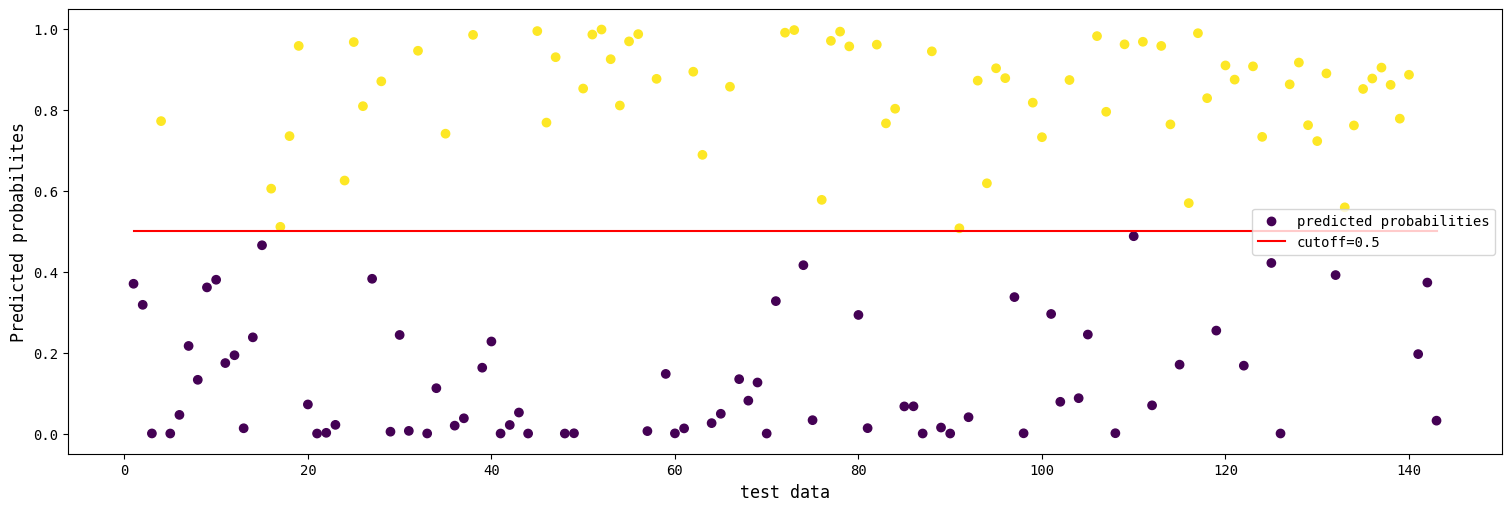

In [ ]:
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
x = range(1, len(predict_probas) + 1)
plt.scatter(x, predict_probas, c=predictions, label='predicted probabilities')
plt.plot(x, [cutoff] * len(predictions), color='red', label='cutoff=0.5')

plt.ylabel('Predicted probabilites', fontsize=12)
plt.xlabel('test data', fontsize=12)
plt.legend(loc=7);

#### Recall the accuracy values using `pipe0`

In [ ]:
print(*accuracies.items())

NameError: ignored

##### We can see from the above plots that there are values close to the cutoff point. Let’s assume that these values were among the mis-classified. Let’s reduce the cutoff value to $0.35$ and observe for improvement:

create a new instance, `pipe1`, with a cutoff value of $0.35$

In [ ]:
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', regularizedLR(learning_rate=1e-2, n_epochs=1000, cutoff=0.35))
])

In [ ]:
pipe1.fit(X_train, y_train)

NameError: ignored

In [ ]:
predictions = pipe1.predict(X_test)
predict_probas = pipe1['lr'].predict_probas
cutoff = pipe1['lr'].cutoff

NameError: ignored

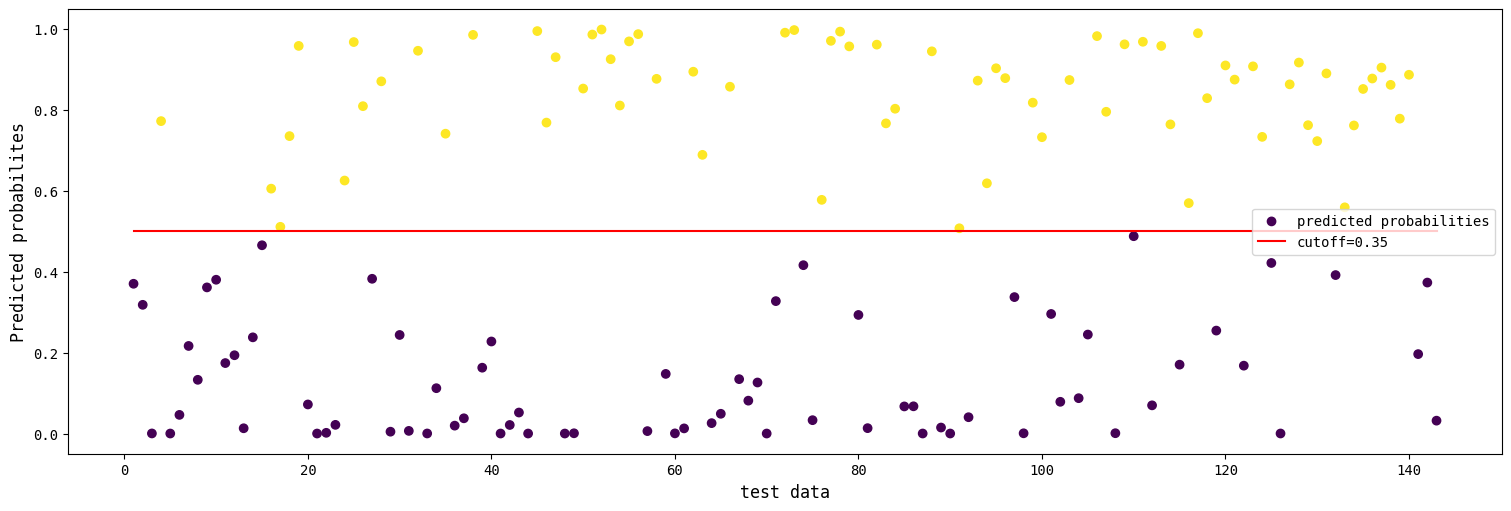

In [ ]:
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
x = range(1, len(predict_probas) + 1)
plt.scatter(x, predict_probas, c=predictions, label='predicted probabilities')
plt.plot(x, [cutoff] * len(predictions), color='red', label='cutoff=0.35')

plt.ylabel('Predicted probabilites', fontsize=12)
plt.xlabel('test data', fontsize=12)
plt.legend(loc=5);

In [ ]:
accuracies1 = {
    'train accuracy': pipe1.score(X_train, y_train),
    'test accuracy': pipe1.score(X_test, y_test)
}

print(*accuracies1.items())

NameError: ignored

##### Although our accuracies did not improve, we’ve learned that we can either increase or decrease our cutoff value from the default, depending on the type of problem we are faced with.

Our custom logistic regression model did not perform badly.